## Monte Carlo for ABRC 
(aka. Snowball structure contract)

In [ ]:
import numpy as np
import pandas as pd
from typing import Optional
!pip install pandas_market_calendars --upgrade
import pandas_market_calendars as mcal

#### Generate Trading Calendar
* Generally, it's avaiable to download trading calendar from exchange one year ahead. 
* Use pandas_market_calendars to estimate the holidays when trading calendar is not avaiable

In [3]:
def get_trade_calendar(start_date,end_date) -> pd.DataFrame:
    sse = mcal.get_calendar('SSE')
    cal=pd.DataFrame(pd.date_range(start=start_date,end=end_date,freq='D'),columns=['date'])
    holidays=list(sse.holidays().holidays)
    holidays = [day for day in holidays if (day>=start_date) & (day <= end_date)]
    bus_date=pd.bdate_range(start=start_date,end=end_date,freq='B')
    cal['is_open']=cal['date'].apply(lambda x : False if x in holidays or x not in bus_date else True)
    return cal

#### Calculate Payoff
Geometric Brownian Motion Dynamics

$\ dS_t = rS_tdt+\sigma S_tdW_t$


In [4]:
def calc_payoff(cal:pd.DataFrame, # trading calendar
                vd=0,             # passed days from initial date
                S0=1,             # initial price
                vd_price=1,       # price at valuation day
                M=10000,          # simulate times
                T=1,              # tenor
                q=0,              # dividend yield of underlying
                r=0.03,           # risk free rate
                sigma=0.13,       # annual volatility
                k_in_price=0.85,  # knock in price
                k_coupon=0.2,     # knock out coupon
                d_coupon=0.2,     # dividend coupon
                Z=None,           # standard normal distribution
                ) -> float:
    
    np.random.seed(42)
    
    dt=T/cal[cal['is_open']==1]['date'].count()  # equal to 1/243 which is exact trading days according to trading calendar per year
    residual_days=cal[vd:]
    trading_days=residual_days[residual_days['is_open']==1].index # trading calendar in residual days
    N=len(trading_days)-1  # residual trading days for simulation 
    
    if Z is None:
        Z = np.random.standard_normal((N,M))

    delta_st=(r-q-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z  # brownian's motion formula
    delta_st=np.concatenate((np.zeros((1,M)),delta_st))
    st=np.cumprod(np.exp(delta_st),axis=0) * vd_price  # generate price list
    st_df=pd.DataFrame(st,index=trading_days)  # same as above in pandas DataFrame, while the index is the days from the initial date 
    
    kout_days=residual_days[residual_days['monitor']==1].index  # record the days between knock out monitor dates and inital date in DataFrame
    kout=np.tile(kout_days,(M,1)).T  # make above days as matrix
    kout=np.where(st_df.loc[kout_days].gt(cal.loc[kout_days,'B_out'],axis=0),kout,np.inf) # use np.inf to replace the above days when underling prices are lower than the knock out prices 
    kout_date=np.min(kout,axis=0)  # find the shortest knock out days
    
    kin=np.any(st<k_in_price,axis=0)  # knock in 
    
    pnl_kout=np.sum(kout_date[kout_date!=np.inf]/365 * k_coupon * np.exp(-r*kout_date[kout_date!=np.inf]/365)) # knock out payoff
    pnl_htm=np.count_nonzero((kout_date==np.inf) & (kin == False)) * d_coupon * np.exp(-r*T)  # hold to maturity payoff 
    pnl_loss=np.sum((st[-1,(kout_date==np.inf) & (kin == True) & (st[-1]<S0)]/S0-1) * np.exp(-r*T))  # knock in loss
    V=(pnl_htm+pnl_kout+pnl_loss)/M
    
    return V

#### Monte Carlo Entry
* params type check
* generate trading calendars
* execute simulation

In [5]:
def simulate(underlying:str,                               # underlaying asset
             initial_price:float,                          # price at initial date, which is a determinant of knock out prices
             start_date:str,                               # initial date
             end_date:str,                                 # end date
             monitor:list,                                 # knock out date which is a monitor
             r:float,                                      # risk free rate
             capital:float,                                # nominal capital
             k_coupon:float,                               # knock out coupon
             k_in_ratio:float,                             # knock in ratio
             k_out_ratios:list,                            # knock out ratio
             k_out_prices:Optional[float] = None,          # knock out prices
             k_in_price:Optional[float] = None,            # knock in price
             d_coupon:Optional[float] = None,              # dividend coupon (hold to maturity coupon)
             vd_price:Optional[float] = None,              # price at valuation day
             vd_date:Optional[str] = None,                 # valution day
             margin_ratio:float = 1,                       # margin rato
             M = 100000,                                   # time for simulation
             unit=True,
             **kwargs): 
    
    """
    use knock out prices when knock out prices and knock out ratios both exists
    
    """

    if monitor[-1]!=end_date:
        end_date = monitor[-1]
    
    if k_out_prices is not None:
        assert len(monitor)==len(k_out_prices),'knock out prices and knock out days are not at same length'
        
    assert isinstance(k_out_prices,list),'knock out prices should be list'
    
    if k_in_price is None:
        k_in_price = initial_price * k_in_ratio             # param
    
    if vd_price is None:
        vd_price = initial_price                            # param
        
    if d_coupon is None:
        d_coupon = k_coupon                                 # param
        
        
    '''trading calendar'''
    st_dt = pd.to_datetime(start_date)                      
    ed_dt = pd.to_datetime(end_date)                        
    T = (ed_dt-st_dt).days/365                              # param
    
    '''mark knock out date and knock out prices'''
    cal=get_trade_calendar(start_date=st_dt,end_date=ed_dt) 
    monitor_idx=cal[cal['date'].isin(list(map(pd.to_datetime,monitor)))].index
    cal['monitor']=np.nan
    cal['B_out']=np.nan
    cal.loc[monitor_idx,'monitor'] = 1
    cal.loc[monitor_idx,'B_out'] = k_out_prices             # param
    
    '''valuation date'''
    if vd_date is None:
        vd = 0
    else:
        vd = (pd.to_datetime(vd_date)-st_dt).days           # param
    
    v = calc_payoff(cal=cal,
                    vd=vd,
                    S0=initial_price,
                    vd_price=vd_price,
                    r=r,
                    M=M,
                    T=T,
                    k_in_price=k_in_price,
                    k_coupon = k_coupon,
                    d_coupon = d_coupon,
                    **kwargs)
    
    if unit:
        return v
    
    return (v+margin_ratio*np.exp(r*vd/365))*margin_ratio*capital*np.exp(r*vd/365)

### Test Input Params

In [6]:
params=dict(
    underlying='',                # underlying asset name                                               
    initial_price = 3000,         # price at initial date, which is a determinant of knock out prices
    start_date = '20220831',      # contract initial date
    end_date = '20230831',        # contract end date
                                  # knock out monitor date
    monitor=['20220928','20221031','20221130','20230104','20230131','20230228','20230331','20230505','20230531','20230630','20230731','20230831'],
                                  # knock out ratios
    k_out_ratios=[1,0.995,0.99,0.985,0.98,0.975,0.97,0.965,0.96,0.955,0.95,0.945],
                                  # knock out prices
    k_out_prices=[3000., 2985., 2970., 2955., 2940., 2925., 2910., 2895., 2880., 2865., 2850., 2835.],
    k_coupon=0.131,               # knock out coupon
    capital=1,                    # nominal capital
    margin_ratio=1,               # margin_ratio
    k_in_ratio=0.75,              # knock in ratio
    sigma=0.15,                   # annual volatility of underlying asset
    q=0,                          # annual dividend yield of underlying asset
    r=0.025,                      # annual risk free rate
)
v=simulate(**params)
v

0.02550440566057516

### Calculate Greeks

In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set_theme()

In [9]:
sigma_lst=[0.1,0.2,0.3,0.4,0.5]
payoffs,delta,gamma,vega,rho,theta=dict(),dict(),dict(),dict(),dict(),dict()
for sigma in sigma_lst:
    payoffs[sigma],delta[sigma],gamma[sigma],vega[sigma],rho[sigma],theta[sigma]=dict(),dict(),dict(),dict(),dict(),dict()
    for vd_price in tqdm(np.arange(1500,4500,30)):
        p = dict(sigma=sigma,vd_price=vd_price)
        params.update(p)
        payoffs[sigma][vd_price] = simulate(**params,M=10000)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


### Unit Payoff

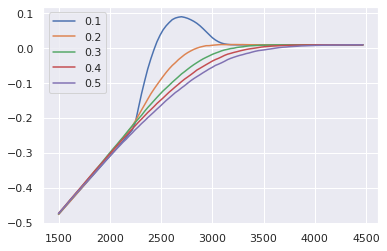

In [16]:
for sigma in sigma_lst:
  plt.plot(list(payoffs[sigma].keys()),list(payoffs[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### Delta

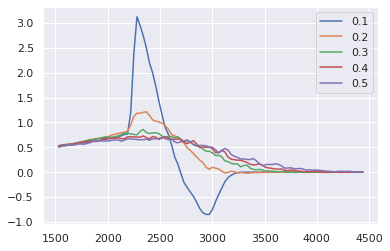

In [17]:
for sigma in sigma_lst:
    for vd_price in np.arange(1530,4470,30):
        delta[sigma][vd_price] = (payoffs[sigma][vd_price+30]-payoffs[sigma][vd_price-30])/(60/vd_price)
for sigma in sigma_lst:
    plt.plot(list(delta[sigma].keys()),list(delta[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### Gamma

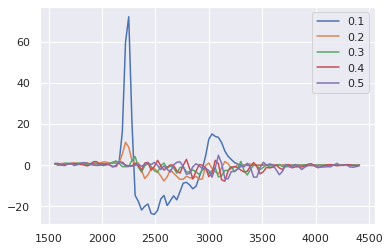

In [18]:
for sigma in sigma_lst:
    for vd_price in np.arange(1560,4440,30):
        gamma[sigma][vd_price] = (delta[sigma][vd_price+30]-delta[sigma][vd_price-30])/(60/vd_price)
for sigma in sigma_lst:
    plt.plot(list(gamma[sigma].keys()),list(gamma[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### Vega

In [19]:
payoffs_v=dict()
for sigma in sigma_lst:
    payoffs_v[sigma]=dict()
    for vd_price in tqdm(np.arange(1500,4500,30)):
        p = dict(sigma=sigma*1.2,vd_price=vd_price)
        params.update(p)
        payoffs_v[sigma][vd_price] = simulate(**params,M=10000)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


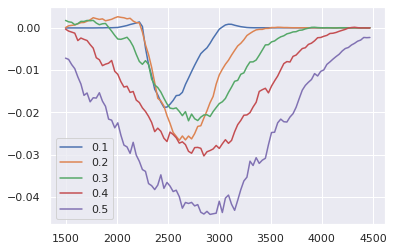

In [20]:
for sigma in sigma_lst:
    for vd_price in np.arange(1500,4500,30):
        vega[sigma][vd_price] = (payoffs_v[sigma][vd_price] - payoffs[sigma][vd_price]) / 0.2*sigma
for sigma in sigma_lst:
    plt.plot(list(vega[sigma].keys()),list(vega[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### Rho

In [21]:
payoffs_r=dict()
for sigma in sigma_lst:
    payoffs_r[sigma]=dict()
    for vd_price in tqdm(np.arange(1500,4500,30)):
        p = dict(sigma=sigma,r=0.025*1.5,vd_price=vd_price)
        params.update(p)
        payoffs_r[sigma][vd_price] = simulate(**params,M=10000)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


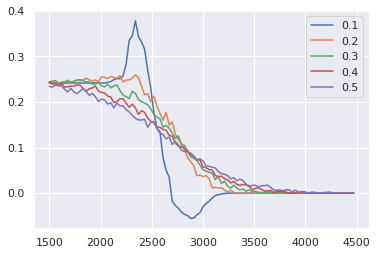

In [22]:
for sigma in sigma_lst:
    for vd_price in np.arange(1500,4500,30):
        rho[sigma][vd_price] = (payoffs_r[sigma][vd_price] - payoffs[sigma][vd_price]) / 0.025*0.5
for sigma in sigma_lst:
    plt.plot(list(rho[sigma].keys()),list(rho[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### Theta vs underlying asset price

In [23]:
payoffs_t=dict()
for sigma in sigma_lst:
    payoffs_t[sigma]=dict()
    for vd_price in tqdm(np.arange(1500,4500,30)):
        p = dict(sigma=sigma,vd_date='20220930',vd_price=vd_price)
        params.update(p)
        payoffs_t[sigma][vd_price] = simulate(**params,M=10000)

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


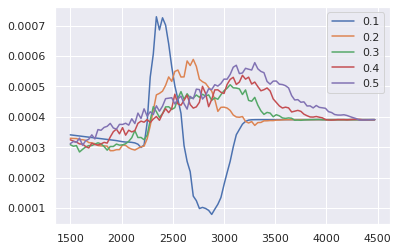

In [24]:
for sigma in sigma_lst:
    for vd_price in np.arange(1500,4500,30):
        theta[sigma][vd_price] = (payoffs_t[sigma][vd_price] - payoffs[sigma][vd_price]) / 30
for sigma in sigma_lst:
    plt.plot(list(theta[sigma].keys()),list(theta[sigma].values()))
plt.legend(sigma_lst)
plt.show()

### to be continued
* Theta as time decay 